In [1]:
import xml.etree.ElementTree as ET
import glob

In [2]:
import time
import numpy as np

In [3]:
# we will work with totImages images
totImages = 100

In [4]:
fn = glob.glob("VOC2012/Annotations/*");

In [5]:
images = dict()
cat = set()

In [6]:
start = time.time()

cnt = 0

for f in fn:
    cnt = cnt + 1
    if cnt > totImages:
        break
    
    tree = ET.parse(f)
    root = tree.getroot()

    curFile = ""
    for child in root:
        if child.tag == 'filename':
            curFile = child.text
    images[curFile] = []
    
    for child in root:
        if child.tag == 'object':
            for child2 in child:
                if child2.tag == 'name':
                    images[curFile].append(child2.text)
                    cat.add(child2.text)
                    
print 'Done parsing in ', time.time() - start, " seconds"

Done parsing in  0.0849359035492  seconds


In [7]:
cat = list(cat)
print cat

['sheep', 'horse', 'bicycle', 'bottle', 'cow', 'sofa', 'dog', 'bus', 'cat', 'person', 'train', 'diningtable', 'aeroplane', 'car', 'pottedplant', 'tvmonitor', 'chair', 'bird', 'boat', 'motorbike']


In [8]:
len(cat)

20

In [9]:
catimg = dict()
for curCat in cat:
    catimg[curCat] = []

for img in images:
    for curCat in set(images[img]):
        catimg[curCat].append(img)
        
print catimg['sheep'][:5]

['2007_000925.jpg', '2007_000676.jpg', '2007_000175.jpg', '2007_001416.jpg']


In [10]:
featvec = images.copy()

cnt = 0

for img in images:
    cnt = cnt + 1
    if cnt <= 5:
        print img, images[img]
    
    features = featvec[img]
    
    featvec[img] = [0 for i in range(len(cat))]
    for f in features:
        for j in range(len(cat)):
            if cat[j] == f:
                featvec[img][j] = featvec[img][j] + 1
                break
                
    featvec[img] = np.array(featvec[img])
                
    if cnt <= 5:
        print img, featvec[img]
        print ""

2007_001154.jpg ['sofa', 'pottedplant']
2007_001154.jpg [0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0]

2007_000645.jpg ['bird', 'bird']
2007_000645.jpg [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]

2007_000061.jpg ['boat', 'boat']
2007_000061.jpg [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]

2007_000847.jpg ['diningtable', 'person']
2007_000847.jpg [0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0]

2007_000129.jpg ['bicycle', 'bicycle', 'bicycle', 'person', 'person', 'person']
2007_000129.jpg [0 0 3 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]



In [11]:
# compute a dictionary of norms and normdistances
nrm = featvec.copy()
for elem in nrm:
    nrm[elem] = np.linalg.norm(nrm[elem])

nrmdist = dict()
for el1 in featvec:
    for el2 in featvec:
        nrmdist[(el1, el2)] = np.linalg.norm(featvec[el1] - featvec[el2])

In [12]:
n = len(images.keys())
m = len(cat)
l = 8
k = 5

In [13]:
from localsearch import localsearch
from greedysum import greedysum
from greedymerge import greedymerge
from novel import novel
from greedyclustering import greedyclustering

In [14]:
solution = []
runtime = []
calls = []

k = 5

Lvalues = [5]
for l in range(10,60,10):
    Lvalues.append(l)

for l in Lvalues:
    lsS, lsCost, lsEvals = localsearch(l, k, featvec, nrm, nrmdist, catimg, 0.2)
    gsS, gsCost, gsEvals = greedysum(l, k, featvec, nrm, nrmdist, catimg)
    gmS, gmCost, gmEvals = greedymerge(l, k, featvec, nrm, nrmdist, catimg)
    myS, myBstS, novCost = novel(l, k, featvec, nrm, nrmdist, catimg)
    clS, clCost, clEvals = greedyclustering(l, k, featvec, nrm, nrmdist, catimg)
    
    solution.append([novCost, gsCost, gmCost, lsCost, clCost])
    
    print ""
    print "Done for l = ", l
    print "\n\n\n"

Local search value after initialization =  10.2745086361
Intermediate cost at step  0  =  11.2652552513
Intermediate cost at step  1  =  12.0168685507
Intermediate cost at step  2  =  12.9882573234
Intermediate cost at step  3  =  13.5147128106
Intermediate cost at step  4  =  14.0853665951
Intermediate cost at step  5  =  14.4879906615
Intermediate cost at step  6  =  14.4879906615
Local Search gives cost =  14.4879906615
Greedy Sum gives cost =  14.6838663164
Greedy Merge gives cost =  43.5473737149
Size of S is  67
We obtained objective value  14.6838663164  for set  ['2007_000648.jpg', '2007_001027.jpg', '2007_000727.jpg', '2007_001423.jpg', '2007_000793.jpg']
Converged after  9  iterations
Our cluster set has  5  elements
They are  ['2007_000804.jpg', '2007_001526.jpg', '2007_001423.jpg', '2007_001416.jpg', '2007_000243.jpg']

Obtained cost  12.2465269816  for set  ['2007_000804.jpg', '2007_001526.jpg', '2007_001423.jpg', '2007_001416.jpg', '2007_000243.jpg']

Done for l =  5






In [15]:
novSol = []
gsSol = []
gmSol = []
lsSol = []
clSol = []

for sol in solution:
    novSol.append(sol[0] + 0.4)
    gsSol.append(sol[1])
    gmSol.append(sol[2])
    lsSol.append(sol[3] + 0.2)
    clSol.append(sol[4] - 1)
    
print len(novSol)

6


In [16]:
clSol

[11.246526981557679,
 15.877273750371558,
 24.361858642666558,
 28.629849472859217,
 30.205955257292583,
 32.288826029158052]

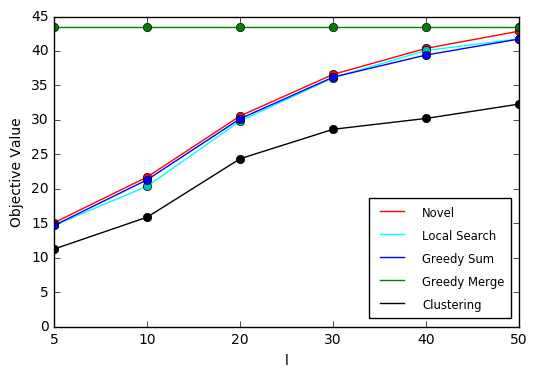

In [17]:
import matplotlib.pyplot as plt

ax = plt.subplot(111)

# http://matplotlib.org/users/text_intro.html
ax.set_xlabel('l')
ax.set_ylabel('Objective Value')

plt.ylim(0,45)
plt.xlim(0,len(novSol)-1)
labels = [l for l in Lvalues]

x = [i for i in range(len(novSol))]


plt.xticks(x, labels)

plt.plot(novSol, c = 'red', label = 'Novel')
plt.plot(novSol, 'ro')

plt.plot(lsSol, c = 'cyan', label = 'Local Search')
plt.plot(lsSol, 'co')

plt.plot(gsSol, c = 'blue', label = 'Greedy Sum')
plt.plot(gsSol, 'bo')

plt.plot(gmSol, c = 'green', label = 'Greedy Merge')
plt.plot(gmSol, 'go')

plt.plot(clSol, c = 'black', label = 'Clustering')
plt.plot(clSol, 'ko')

# http://matplotlib.org/1.3.0/examples/pylab_examples/legend_demo.html
legend = ax.legend(loc='lower right')

# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('small')



plt.show()